In [10]:
# Load the Datasets
import torch
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [11]:
default_batch_size = 64

In [12]:
# LOAD CIFAR 10
# Cifar transform to preprocess the data
transcform_cifar_norm = transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5)).to(default_device)
# TODO - add norm
transform_cifar = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=default_batch_size, shuffle=True, num_workers=2)

# Download and load the test data
testset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=default_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


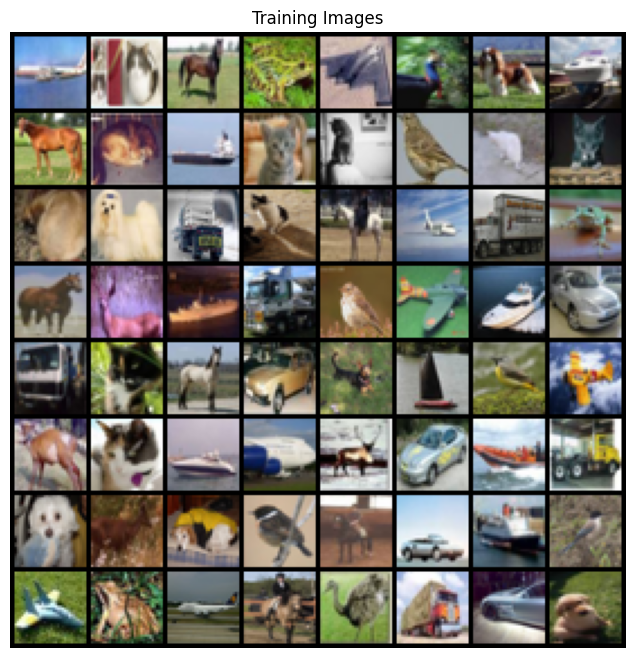

In [13]:
# Print some of the CIFAR dataset samples if flag is set
print_sample = True
if print_sample:
    real_batch = next(iter(trainloader_cifar))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [14]:
class VAE_conv(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE_conv, self).__init__()
        channel_size = 32

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, channel_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_size, channel_size * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_size * 2, channel_size * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(channel_size * 4 * 4 * 4, latent_size * 2)  # Adjusted for mu and log_var
        ).to(default_device)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, channel_size * 4 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (channel_size * 4, 4, 4)),
            nn.ConvTranspose2d(channel_size * 4, channel_size * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_size * 2, channel_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        ).to(default_device)

        # Latent space
        self.fc_mu = nn.Linear(hidden_size, latent_size).to(default_device)
        self.fc_log_var = nn.Linear(hidden_size, latent_size).to(default_device)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)  # Split into mu and log_var

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        x_recon = self.decoder(z)

        return x_recon, mu, log_var
    
def vae_loss_function_conv(recon_x, x, mu, log_var):
    # Flatten recon_x to match the shape of x
    recon_x_flat = recon_x.view(x.size())

    BCE = nn.functional.binary_cross_entropy(recon_x_flat, x, reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return (BCE, KLD)

In [15]:
def train_vae_conv(model, trainloader, optimizer, num_epochs, input_size):
    # Training loop
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.to(default_device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(inputs)

            # Reshape the inputs for the loss function
            inputs_flat = inputs.view(-1, 3, 32, 32)
            recon_batch_flat = recon_batch.view(-1, 3, 32, 32)

            # Binary cross entropy, KL divergence
            (BCE, KLD) = vae_loss_function_conv(recon_batch_flat, inputs, mu, log_var)
            loss = BCE + KLD

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            if i % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(trainloader), BCE.item(), KLD.item(), loss.item()))

In [16]:
# CIFAR 10 Data Training - Conv
input_size = 32 * 32 * 3 # Size of CIFAR images - 3072
hidden_size = 512 # Hidden size for hidden layer ** relationship in the cnn architecture so can't just change this
latent_size = 512 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 10 # Number of epochs to train for

# CNN

# Initialize the model
vae_model_cifar = VAE_conv(input_size, hidden_size, latent_size)

# Optimizer
optimizer = optim.Adam(vae_model_cifar.parameters(), lr=learning_rate)

# Train the model
train_vae_conv(vae_model_cifar, trainloader_cifar, optimizer, num_epochs, input_size)

Epoch [1/10], Step [1/782], BCE: 136359.4062, KLD: 8.0468, Total Loss: 136367.4531
Epoch [1/10], Step [501/782], BCE: 122529.7344, KLD: 1910.1396, Total Loss: 124439.8750
Epoch [2/10], Step [1/782], BCE: 118907.3594, KLD: 2366.3665, Total Loss: 121273.7266
Epoch [2/10], Step [501/782], BCE: 118266.9609, KLD: 2344.5386, Total Loss: 120611.5000
Epoch [3/10], Step [1/782], BCE: 115455.1484, KLD: 2301.3496, Total Loss: 117756.5000
Epoch [3/10], Step [501/782], BCE: 118490.8750, KLD: 2079.6050, Total Loss: 120570.4766
Epoch [4/10], Step [1/782], BCE: 112107.9531, KLD: 2300.2048, Total Loss: 114408.1562
Epoch [4/10], Step [501/782], BCE: 114540.1094, KLD: 2361.7437, Total Loss: 116901.8516
Epoch [5/10], Step [1/782], BCE: 114253.8125, KLD: 2466.9570, Total Loss: 116720.7656
Epoch [5/10], Step [501/782], BCE: 110701.3750, KLD: 2672.4604, Total Loss: 113373.8359
Epoch [6/10], Step [1/782], BCE: 112862.2734, KLD: 2485.3186, Total Loss: 115347.5938
Epoch [6/10], Step [501/782], BCE: 120156.0938,

C:\Users\Nathan\AppData\Local\Temp\ipykernel_22432\888861899.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(np.transpose(vutils.make_grid(torch.tensor(real_images[:default_batch_size]).to(default_device), padding=2, normalize=True).cpu(),(1,2,0)))


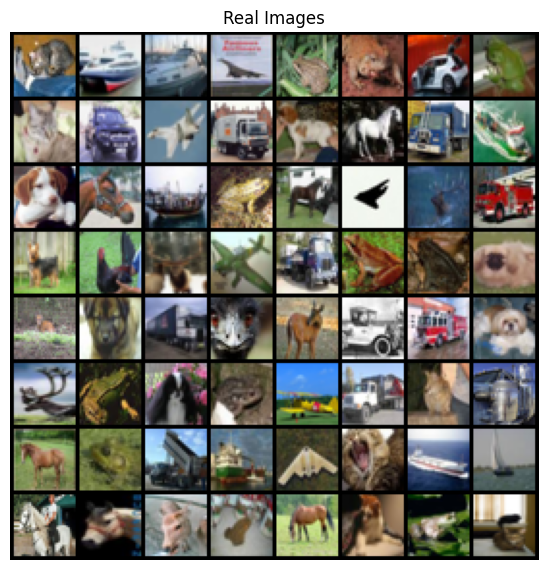

C:\Users\Nathan\AppData\Local\Temp\ipykernel_22432\888861899.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(np.transpose(vutils.make_grid(torch.tensor(recon_images[:default_batch_size]).to(default_device), padding=2, normalize=True).cpu(),(1,2,0)))


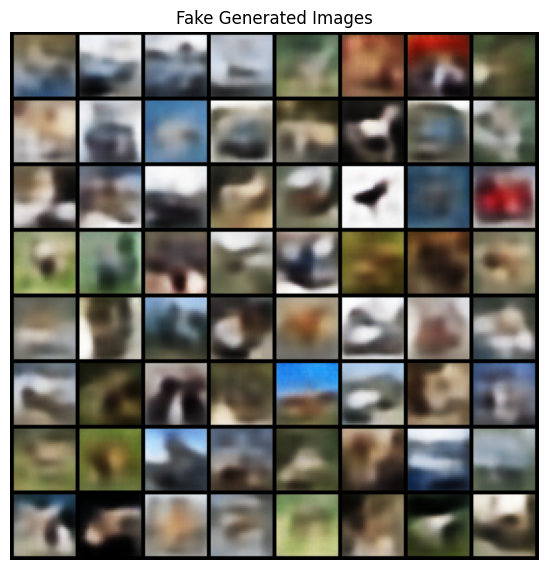

In [24]:
import torchvision
import torchvision.transforms as transforms

num_rows = 10
vae_model_cifar.eval()

with torch.no_grad():
    # Get a batch of real images
    real_images, _ = next(iter(testloader_cifar))
    real_images = real_images.to(default_device)

    # Generate images using the VAE
    recon_images, _, _ = vae_model_cifar(real_images)

# Plot the fake images from the last epoch
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(torch.tensor(real_images[:default_batch_size]).to(default_device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Generated Images")
plt.imshow(np.transpose(vutils.make_grid(torch.tensor(recon_images[:default_batch_size]).to(default_device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
# Side by side image comparison

import torchvision
import torchvision.transforms as transforms

num_rows = 10
vae_model_cifar.eval()

with torch.no_grad():
    # Get a batch of real images
    real_images, _ = next(iter(testloader_cifar))
    real_images = real_images.to(default_device)

    # Generate images using the VAE
    recon_images, _, _ = vae_model_cifar(real_images)

# Display the images
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 2 * num_rows))
for i in range(num_rows):
    # Display real images
    axes[i, 0].imshow(torchvision.utils.make_grid(real_images[i].cpu(), nrow=1).permute(1, 2, 0))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Real Image')

    # Display generated images
    axes[i, 1].imshow(torchvision.utils.make_grid(recon_images[i].cpu(), nrow=1).permute(1, 2, 0))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Generated Image')

plt.show()